In [1]:
#Import libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from scipy import stats
import math
import os
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.datasets import make_regression
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score

# 5.4 Regularized Regressions

## 5.4.1 Some theory to start off with

**What is Regularization?**

When you have too many parameters in your model, there is a risk of overfitting, i.e. your model learns the noise. To avoid this, techniques have been developed to make an estimation of this noise. 

Regularization helps to solve over fitting problem in machine learning. A simple model will be a very poor generalization of data. At the same time, a complex model may not perform well in test data due to over fitting. We need to choose the right model in between simple and complex model. Regularization helps to choose preferred model complexity, so that model is better at predicting. **Regularization is nothing but adding a penalty term to the objective function to control the model complexity using that penalty term.** It can be used for many machine learning algorithms.

The effect in practice is that it makes sure the weights of linear regression remain small and thus less over-fitting.

**When to use Regularized linear regression?**

Whenever you are facing one of these situations: 
- large number of variables 
- low ratio of no. observations to no. variables
- high multicollinearity (predictors are correlated with each other)


**Ridge (L2 regularization)**

$$ \text{min} \sum_i || \hat{y}_i  - y_i||^2  + \alpha \beta^2 $$ 

- Penalty: sum of the squares of the coefficients
- Bigger penalization on high coefficients, small penalization on low coefficients 


**Lasso (L1 regularization)** 

$$ \text{min} \sum_i || \hat{y}_i  - y_i||^2  + \alpha |\beta|$$ 

- Penalty: sum of the absolute values of the coefficients
- Uniform penalization on all coefficients

**Lasso or Ridge?**

- Ridge: when you have many small / medium sized effects you should go with ridge, as it will leave all variables in your model. 
- Lasso: If you have only a few variables with a medium / large effect, with many features not relevant, as it will drop unnecessary variables from the model. 

## 5.4.2 A simple example

### 5.4.2.1 Create a dataset

We will create a dataset with 200 samples (thinks rows in the dataframe), but 30 variables (thinks columns in the dataframe). This is a lot of variables for few observations. Of these 30 only 10 are good for prediction, the rest just add noise instead of structure.

In [2]:
#this creates the toy data for the rest of the excercise
X, y, true_coefficient = make_regression(n_samples=200, 
                                         n_features=30, 
                                         n_informative=10, 
                                         noise=100, 
                                         coef=True, random_state
                                         =5)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    random_state=5, 
                                                    train_size=60)
print(X_train.shape)
print(y_train.shape)

(60, 30)
(60,)


/Users/AVNH/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### 5.4.2.2 See how a simple linear regression performs

In [4]:
linear_regression  =LinearRegression().fit(X_train, y_train)
print("R^2 on training set: %f" % linear_regression.score(X_train, y_train))
print("R^2 on test set: %f" % linear_regression.score(X_test, y_test))

R^2 on training set: 0.878011
R^2 on test set: 0.216332


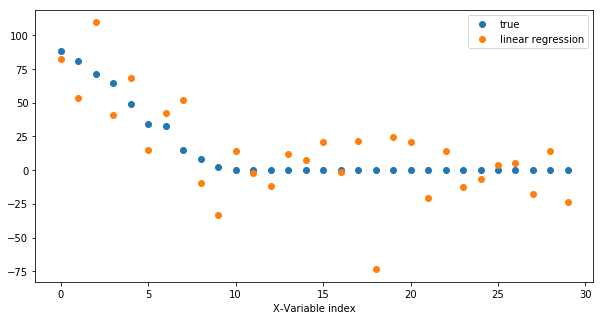

In [5]:
plt.figure(figsize=(10, 5))
coefficient_sorting = np.argsort(true_coefficient)[::-1]
plt.plot(true_coefficient[coefficient_sorting], "o", label="true")
plt.plot(linear_regression.coef_[coefficient_sorting], "o", label="linear regression")
plt.xlabel("X-Variable index")
plt.legend()
plt.show()

This plot compares the "true" indices (blue) for the linear regression model, i.e. the ones that have been created to create the actual data - versus the indices that have been predicted by the model (orange). The 'true' blue ones are ranked by how big (i.e. important) they are. You can see that only 10 are informative (non zero).

If the model would perfectly capture the 'true' structure behind the data, the orange and blue dots would be identical. It is apparent that there are considerable differences between these values! 

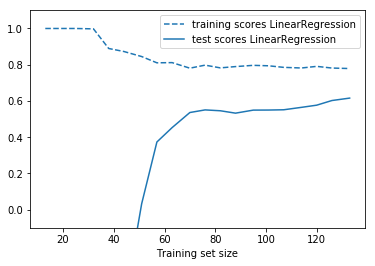

In [6]:
def plot_learning_curve(est, X, y):
    training_set_size, train_scores, test_scores = learning_curve(est, X, y,cv=3, train_sizes=np.linspace(.1, 1, 20))
    estimator_name = est.__class__.__name__
    line = plt.plot(training_set_size, train_scores.mean(axis=1), '--', label="training scores " + estimator_name)
    plt.plot(training_set_size, test_scores.mean(axis=1), '-', label="test scores " + estimator_name, c=line[0].get_color())
    plt.xlabel('Training set size')
    plt.legend(loc='best')
    plt.ylim(-0.1, 1.1)

plt.figure()    
plot_learning_curve(LinearRegression(), X, y)
plt.show()

The learning curve clearly shows that increasing the size of the training set results in higher scores. 

### 5.4.2.3 See how this improves when using a Ridge regression

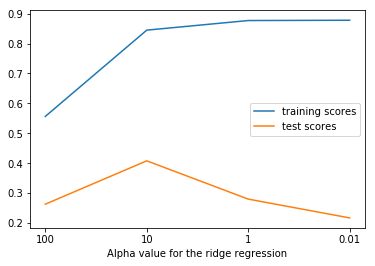

In [7]:
from sklearn.linear_model import Ridge
ridge_models = {}
training_scores = []
test_scores = []

for alpha in [100, 10, 1, .01]:
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    training_scores.append(ridge.score(X_train, y_train))
    test_scores.append(ridge.score(X_test, y_test))
    ridge_models[alpha] = ridge

plt.figure()
plt.plot(training_scores, label="training scores")
plt.plot(test_scores, label="test scores")
plt.xticks(range(4), [100, 10, 1, .01])
plt.legend(loc="best")
plt.xlabel("Alpha value for the ridge regression")
plt.show()

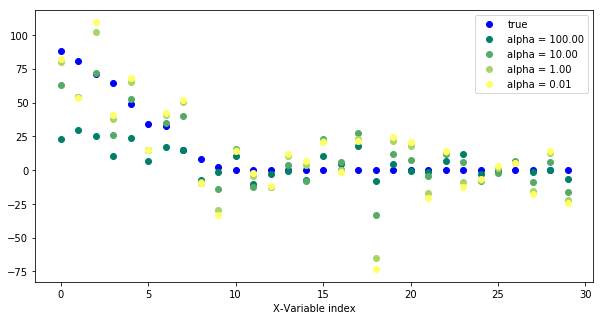

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(true_coefficient[coefficient_sorting], "o", label="true", c='b')

for i, alpha in enumerate([100, 10, 1, .01]):
    plt.plot(ridge_models[alpha].coef_[coefficient_sorting], "o", label="alpha = %.2f" % alpha, c=plt.cm.summer(i / 3.))
    
plt.legend(loc="best")
plt.xlabel("X-Variable index")
plt.show()

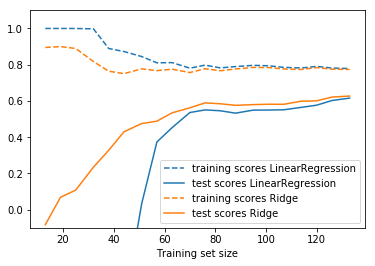

In [9]:
plt.figure()
plot_learning_curve(LinearRegression(), X, y)
plot_learning_curve(Ridge(alpha=10), X, y)
plt.show()

This graph clearly shows that the performance of the Ridge regression are typically better on the test dataset, and worse on the training set.

This is exactly the desired behaviour, avoiding overfitting to the training data. 

## Question

Assume that you are a very silly data scientist and you are tuning the parameters of your model on your complete dataset, i.e. you have not created a test and validation set. What will be the optimal parameter $\alpha$ for your Lasso or Ridge regression?